### Описание задания

Построить модель классификации: по снимкам с камеры на рыболовецком судне классифицировать улов. В качестве датасета взят [The Nature Conservancy Fisheries Monitoring](https://www.kaggle.com/competitions/the-nature-conservancy-fisheries-monitoring) с Kaggle.

## Для проверяющего.

Добрый день.

Прошу дать рекомендации по выполнению задания. Функции encode_anchors и decode_prediction расширил, чтобы они содержали информацию о метке.
Но не могу придумать, как перейти к передаче категориальных меток в ункцию total-loss и предсказанию метки.
Какой steps_per_epoch лучше выбрать для задания, так как формула
sum(map(len, boxes.values()), 0) / batch_size даёт более 300  вызовов на epoch.

In [1]:
import json
import os

import cv2
from glob import glob
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from random import shuffle

from sklearn.metrics import log_loss

import tensorflow as tf
from tensorflow.keras.applications import vgg16
from tensorflow.keras.optimizers import SGD

print(tf.__version__)

2.12.0


### Загрузка разметок изображений

In [2]:
TRAIN_PREFIX = '/content/drive/MyDrive/Colab Notebooks/CV/Fish/data/train'

#Functions for images
def load_boxes():
    boxes = dict()
    for path in glob('/content/drive/MyDrive/Colab Notebooks/CV/Fish/data/boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            boxes[label] = json.load(src)
            for annotation in boxes[label]:
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(TRAIN_PREFIX, label.upper(), basename)
                annotation['class'] = os.path.split(os.path.dirname(annotation['filename']))[1]
            for annotation in boxes[label]:
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):
    '''Draw border of fishes'''

    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2,
                                color=color, thickness=4)
        return img

    scale_x, scale_y = 1., 1.

    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)

    img = _draw(img, annotation.get('annotations'), scale_x, scale_y)

    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

In [3]:
boxes = load_boxes()

In [4]:
list(boxes.values())[0][1]

{'annotations': [{'class': 'rect',
   'height': 195.0,
   'width': 346.0,
   'x': 452.0,
   'y': 258.5},
  {'class': 'rect', 'height': 178.0, 'width': 353.0, 'x': 770.5, 'y': 179.0}],
 'class': 'BET',
 'filename': '/content/drive/MyDrive/Colab Notebooks/CV/Fish/data/train/BET/img_07804.jpg'}

Число объектов по классам

In [5]:
pd.DataFrame(
    [(k, len(v)) for k, v in boxes.items()],
    columns=['class', 'count'])

,class,count
0,bet,200
1,yft,734
2,dol,117
3,lag,67
4,shark,176
5,alb,1719


Наблюдается сильный дисбаланс классов.

In [6]:
labels = sorted(list(map(str.upper, list(boxes.keys()))) + ['NoF','OTHER'])

print(labels)

['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']


In [7]:
count_labels = len(labels)

### Визуализация разметки изображения

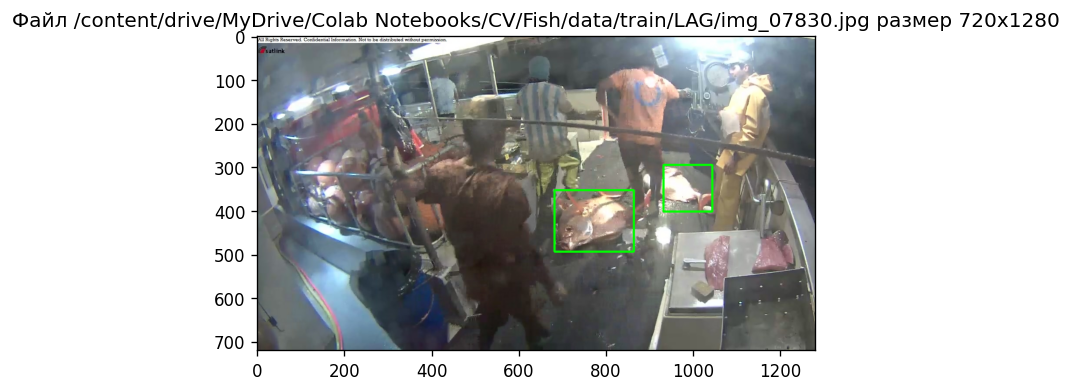

In [8]:
annotation = boxes['lag'][1]
img = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title('Файл {} размер {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

### Распределение размеров рамок объектов

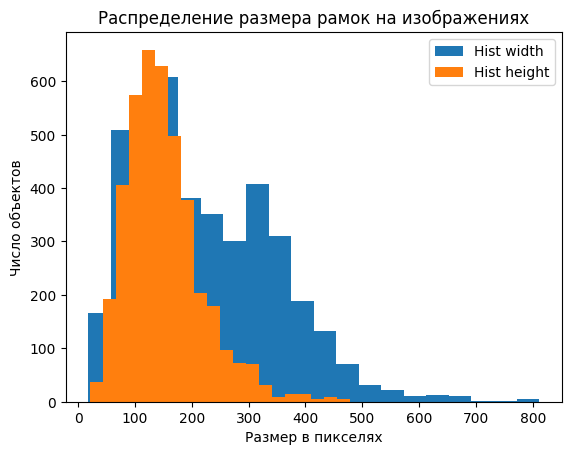

In [9]:
annotations = sum([box['annotations']
                   for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths, bins=20)
plt.hist(heights, bins=20)
plt.title('Распределение размера рамок на изображениях')
plt.legend(['Hist width','Hist height'], loc='upper right')
plt.xlabel('Размер в пикселях')
plt.ylabel('Число объектов')
plt.show()

### Экстрактор признаков

In [10]:
IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = vgg16.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

for layer in features.layers[:-5]:
    layer.trainable = False

feature_tensor = features.layers[-1].output
print(feature_tensor.shape)

(None, 23, 37, 512)


### Создание сетки якорей (anchor grid)

In [11]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150.

ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [12]:
#Functions for anchor grid
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    '''Return IoU metrics'''

    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale

    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale

    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2

    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))

    intersection = dx * dy if (dx > 0 and dy > 0) else 0.

    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection

    return intersection / union

def encode_anchors(annotation, img_shape, iou_thr=0.5):
    '''Encode annotation for NN'''
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1],
                              5 + count_labels), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    y = annotation['class']
    for rect in annotation['annotations']:
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))

        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = [1., dx, dy, dw, dh] + [int(label == y) for label in labels]

    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    '''Decode annotation from NN'''
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            logit, dx, dy, dw, dh = prediction[row, col][:5] #only rectangle params
            conf = _sigmoid(logit)
            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf})
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    '''Delete duplicate of boxes'''
    if not rectangles:
        return rectangles

    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)

    return [rectangles[i] for i in indices]

### Валидация энкодинга/декодинга якорей

In [13]:
example = boxes['lag'][1]

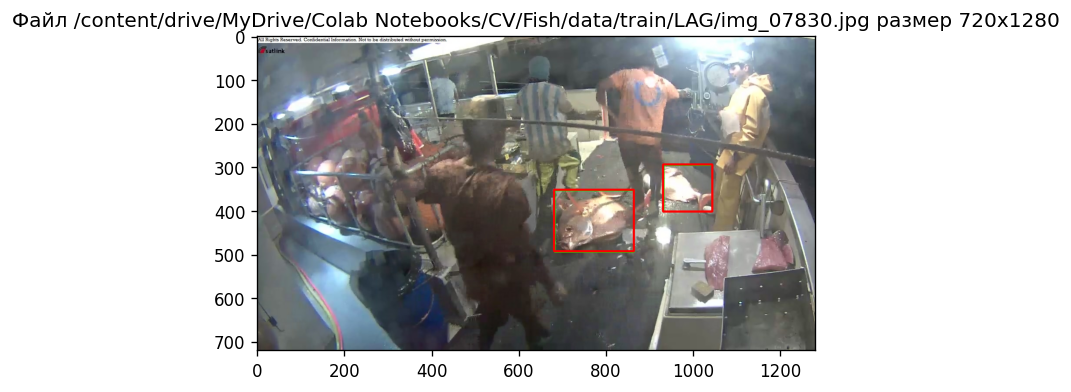

In [14]:
encoded = encode_anchors(example,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         iou_thr=0.5)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(example, decoded))
plt.title('Файл {} размер {}x{}'.format(
    example['filename'], img.shape[0], img.shape[1]));

Валидация пройдена, так как наблюдается полное перекрытие размеченной рамки рамкой декодера.

### Функция потерь

In [15]:
#Loss functions
K = tf.keras.backend

def classification_loss(y_true, y_pred):
    cce = tf.keras.losses.CategoricalCrossentropy()
    return cce(y_true, y_pred)

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0],
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:] - y_pred[..., 1:])
    square_loss = 0.5 * K.square(y_true[..., 1:] - y_pred[..., 1:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]

    y_true = K.reshape(y_true, (batch_size, -1, 5))
    y_pred = K.reshape(y_pred, (batch_size, -1, 5))

    # classification_loss
    class_loss = classification_loss(y_true, y_pred)

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)

    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)

    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)

    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])

    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)

    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)

    return total_conf_loss + 0.5 * loc_loss + class_loss


### Загрузка данных

In [16]:
#Functions for load data
def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    '''Load image'''
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    '''Make generator of data'''
    boxes = sum(boxes.values(), [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                y.append([float(boxes[j]['class'] == label) for label in labels])
                X.append(img)
            yield np.array(X), np.array(y)

### Добавление выхода детектора

In [17]:
output = tf.keras.layers.Flatten()(feature_tensor)
output = tf.keras.layers.Dense(256, activation='relu')(output)
output = tf.keras.layers.Dropout(0.4)(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dense(8, activation='softmax')(output)

model = tf.keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 750, 1200, 3)]    0         
                                                                 
 block1_conv1 (Conv2D)       (None, 750, 1200, 64)     1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 750, 1200, 64)     36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 375, 600, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 375, 600, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 375, 600, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 187, 300, 128)     0     

### Обучение модели

In [18]:
model.compile(optimizer=SGD(learning_rate=1e-3),
              # loss='categorical_crossentropy',
              loss=total_loss,
              metrics=[confidence_loss])

In [19]:
batch_size = 10

gen = data_generator(boxes, batch_size=batch_size)
steps_per_epoch = sum(map(len, boxes.values()), 0) / batch_size

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'fishdetector.hdf5',
    monitor='loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq=10)

model.fit(gen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          callbacks=[checkpoint])

Epoch 1/10


InvalidArgumentError: ignored

### Результат работы детектора

In [ ]:
annotation = boxes['lag'][0]

_, sample_img = load_img(annotation['filename'])
pred = model.predict(np.array([sample_img,]))

decoded = decode_prediction(pred[0], conf_thr=0.2)
decoded = non_max_suppression(decoded,
                              max_output_size=5,
                              iou_threshold=0.1)

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('Предсказание модели {}x{}'.format(*img.shape));

### Визуализиция предсказания на test данных

In [ ]:
test_images = glob('data/test_stg1/*.jpg')[:5]


plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0], conf_thr=0.0)
    decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.1)

    plt.subplot(len(test_images), 1, i + 1)
    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    plt.title('Предсказание на тесте {}'.format(filename));

### Агрегация результатов

In [ ]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0